# Fall 2020: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 2: Neural Language Modeling (30 pts)
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [3]:
# Import required packages
import os
import json
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt

In [2]:
 !pip install jsonlines

---
### 1 LSTM and Hyper-parameters (10 pts)
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data

In [4]:
import os
from tqdm import tqdm
import jsonlines
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy
import matplotlib.pyplot as plt

In [5]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [6]:
datasets, vocab = load_wikitext()

--2020-11-12 01:34:17--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 185.235.236.197
Connecting to nyu.box.com (nyu.box.com)|185.235.236.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2020-11-12 01:34:18--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2020-11-12 01:34:18--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 185.235.236.201
Connecting to nyu.app.box.com (nyu.app.box.com)|185.235.236.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [7]:
class Dictionary(object): #maps words to indices
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>') #beginning of sentence
        self.add_token('<eos>') #end of sentence
        self.add_token('<pad>')
        self.add_token('<unk>') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [8]:
data_dict = Dictionary(datasets, include_valid=True)

100%|██████████| 8464/8464 [00:09<00:00, 885.74it/s]


In [9]:
def tokenize_dataset(datasets, dictionary, ngram_order=2): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [10]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [11]:
tokenized_datasets = tokenize_dataset(datasets, data_dict)
tensor_dataset = {}

for split, listoflists in tokenized_datasets.items():
    tensor_dataset[split] = TensoredDataset(listoflists)

100%|██████████| 9708/9708 [00:00<00:00, 139532.74it/s]


In [12]:
# check the first example
tensor_dataset['train'][0]

(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [13]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = data_dict.get_id('<pad>')
    #pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [14]:
data_loaders = {}

batch_size = 128

for split, wiki_data in tensor_dataset.items():
    data_loaders[split] = DataLoader(wiki_data, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

In [15]:
data_loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fda7c4aa9b0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fda84150eb8>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7fda84150e48>}

#### Model + Training (5 pts)

In [16]:
class LSTMLanguageModel(nn.Module): 
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['rnn_dropout'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence, hidden):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_outputs, hidden = self.lstm(embeddings)
        logits = self.projection(lstm_outputs.reshape(-1, options['hidden_size']))
        return logits, hidden

    def init_state(self, batch_size):
        return (torch.zeros(options['num_layers'], batch_size, options['hidden_size']),
            torch.zeros(options['num_layers'], batch_size, options['hidden_size']))

In [43]:
# create a model 
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
    
embedding_size = 256
hidden_size = 512
num_layers = 3
lstm_dropout = 0.3

options = {
    'num_embeddings': len(data_dict),
    'embedding_dim': embedding_size,
    'padding_idx': data_dict.get_id('<pad>'),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'rnn_dropout': lstm_dropout,
    }

In [44]:
# Train the model
model = LSTMLanguageModel(options).to(current_device)
best_model = copy.deepcopy(model)
criterion = nn.CrossEntropyLoss(ignore_index=data_dict.get_id('<pad>'))
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)
max_patience = 3
patience = 0
next_min = 100000
plot_cache = []

for epoch_number in range(100):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in enumerate(data_loaders['train']):
        s1, s2 = model.init_state(batch_size)
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits, (s1, s2) = model(inp, (s1, s2))
        s1, s2 = s1.detach(), s2.detach()
        
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()

        train_log_cache.append(loss.item())

        if i % 100 == 0:
            avg_loss = sum(train_log_cache)/len(train_log_cache)
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(data_loaders['valid']):
            s1, s2 = model.init_state(batch_size) # cell state / hidden state
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, (s1, s2) = model(inp, (s1, s2))
            s1, s2 = s1.detach(), s2.detach()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())

        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

    plot_cache.append((avg_loss, avg_val_loss))
    if (avg_val_loss < next_min):
        next_min = avg_val_loss
        best_model = copy.deepcopy(model)
        patience = 0
    else:
        patience += 1
        if patience == max_patience:
            break

Step 0 avg train loss = 10.4117
Step 100 avg train loss = 10.3833
Step 200 avg train loss = 10.2065
Step 300 avg train loss = 9.4739
Step 400 avg train loss = 8.6129
Step 500 avg train loss = 8.3414
Step 600 avg train loss = 8.0630
Validation loss after 0 epoch = 7.8589
Step 0 avg train loss = 8.0941
Step 100 avg train loss = 7.9591
Step 200 avg train loss = 7.8647
Step 300 avg train loss = 7.8068
Step 400 avg train loss = 7.7790
Step 500 avg train loss = 7.6941
Step 600 avg train loss = 7.6632
Validation loss after 1 epoch = 7.4834
Step 0 avg train loss = 7.5896
Step 100 avg train loss = 7.6087
Step 200 avg train loss = 7.5536
Step 300 avg train loss = 7.4757
Step 400 avg train loss = 7.4115
Step 500 avg train loss = 7.3703
Step 600 avg train loss = 7.3374
Validation loss after 2 epoch = 7.1617
Step 0 avg train loss = 7.2783
Step 100 avg train loss = 7.2946
Step 200 avg train loss = 7.2486
Step 300 avg train loss = 7.2175
Step 400 avg train loss = 7.1697
Step 500 avg train loss = 7.12

In [45]:
torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, f'/content/lstm_5.pt')

In [ ]:
best_model
# the best model will be used in Q2 and Q3

LSTMLanguageModel(
  (lookup): Embedding(33181, 256, padding_idx=2)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True, dropout=0.3)
  (projection): Linear(in_features=512, out_features=33181, bias=True)
)

#### Performance variation based on hyper-parameter values (5 pts)


In [18]:
# find and choose two hyper-parameters
embedding_size = [256, 512]
hidden_size = [256, 512]
num_layers = 2
lstm_dropout = 0.3

##### model 1: embedding 128 + hidden 256

In [26]:
embedding_size = 128
hidden_size = 256
num_layers = 2
lstm_dropout = 0.3

options = {
      'num_embeddings': len(data_dict),
      'embedding_dim': embedding_size,
      'padding_idx': data_dict.get_id('<pad>'),
      'input_size': embedding_size,
      'hidden_size': hidden_size,
      'num_layers': num_layers,
      'rnn_dropout': lstm_dropout,
      }
model = LSTMLanguageModel(options).to(current_device)
criterion = nn.CrossEntropyLoss(ignore_index=data_dict.get_id('<pad>'))
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

max_patience = 3
patience = 0
next_min = 100000
plot_cache = []
for epoch_number in range(100):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in enumerate(data_loaders['train']):
        s1, s2 = model.init_state(batch_size)
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits, (s1, s2) = model(inp, (s1, s2))
        s1, s2 = s1.detach(), s2.detach()
        
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()

        train_log_cache.append(loss.item())

        if i % 100 == 0:
            avg_loss = sum(train_log_cache)/len(train_log_cache)
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(data_loaders['valid']):
            s1, s2 = model.init_state(batch_size)
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, (s1, s2) = model(inp, (s1, s2))
            s1, s2 = s1.detach(), s2.detach()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())

        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

    plot_cache.append((avg_loss, avg_val_loss))
    if (avg_val_loss < next_min):
        next_min = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience == max_patience:
            break

Step 0 avg train loss = 10.4064
Step 100 avg train loss = 10.3780
Step 200 avg train loss = 10.2042
Step 300 avg train loss = 9.5361
Step 400 avg train loss = 8.6398
Step 500 avg train loss = 8.4661
Step 600 avg train loss = 8.0977
Validation loss after 0 epoch = 7.8457
Step 0 avg train loss = 7.9948
Step 100 avg train loss = 7.8981
Step 200 avg train loss = 7.7963
Step 300 avg train loss = 7.6931
Step 400 avg train loss = 7.6537
Step 500 avg train loss = 7.6155
Step 600 avg train loss = 7.5668
Validation loss after 1 epoch = 7.4139
Step 0 avg train loss = 7.5678
Step 100 avg train loss = 7.5244
Step 200 avg train loss = 7.4870
Step 300 avg train loss = 7.4424
Step 400 avg train loss = 7.3782
Step 500 avg train loss = 7.3474
Step 600 avg train loss = 7.3121
Validation loss after 2 epoch = 7.1388
Step 0 avg train loss = 7.3040
Step 100 avg train loss = 7.2688
Step 200 avg train loss = 7.2263
Step 300 avg train loss = 7.1860
Step 400 avg train loss = 7.1533
Step 500 avg train loss = 7.10

In [27]:
torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, f'/content/lstm_1.pt')

##### model 2: embedding 128 + hidden 512

In [28]:
embedding_size = 128
hidden_size = 512
num_layers = 2
lstm_dropout = 0.3

options = {
      'num_embeddings': len(data_dict),
      'embedding_dim': embedding_size,
      'padding_idx': data_dict.get_id('<pad>'),
      'input_size': embedding_size,
      'hidden_size': hidden_size,
      'num_layers': num_layers,
      'rnn_dropout': lstm_dropout,
      }
model = LSTMLanguageModel(options).to(current_device)
criterion = nn.CrossEntropyLoss(ignore_index=data_dict.get_id('<pad>'))
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

max_patience = 3
patience = 0
next_min = 100000
plot_cache = []
for epoch_number in range(100):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in enumerate(data_loaders['train']):
        s1, s2 = model.init_state(batch_size)
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits, (s1, s2) = model(inp, (s1, s2))
        s1, s2 = s1.detach(), s2.detach()
        
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()

        train_log_cache.append(loss.item())

        if i % 100 == 0:
            avg_loss = sum(train_log_cache)/len(train_log_cache)
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(data_loaders['valid']):
            s1, s2 = model.init_state(batch_size)
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, (s1, s2) = model(inp, (s1, s2))
            s1, s2 = s1.detach(), s2.detach()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())

        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

    plot_cache.append((avg_loss, avg_val_loss))
    if (avg_val_loss < next_min):
        next_min = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience == max_patience:
            break

Step 0 avg train loss = 10.4098
Step 100 avg train loss = 10.3819
Step 200 avg train loss = 10.1981
Step 300 avg train loss = 9.4127
Step 400 avg train loss = 8.5869
Step 500 avg train loss = 8.2915
Step 600 avg train loss = 8.0111
Validation loss after 0 epoch = 7.8063
Step 0 avg train loss = 7.9789
Step 100 avg train loss = 7.8720
Step 200 avg train loss = 7.7306
Step 300 avg train loss = 7.6628
Step 400 avg train loss = 7.5922
Step 500 avg train loss = 7.5468
Step 600 avg train loss = 7.5014
Validation loss after 1 epoch = 7.3714
Step 0 avg train loss = 7.4116
Step 100 avg train loss = 7.4431
Step 200 avg train loss = 7.3847
Step 300 avg train loss = 7.3357
Step 400 avg train loss = 7.2937
Step 500 avg train loss = 7.2519
Step 600 avg train loss = 7.1978
Validation loss after 2 epoch = 7.0343
Step 0 avg train loss = 7.1793
Step 100 avg train loss = 7.1458
Step 200 avg train loss = 7.1071
Step 300 avg train loss = 7.0554
Step 400 avg train loss = 7.0239
Step 500 avg train loss = 6.99

In [29]:
torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, f'/content/lstm_2.pt')

##### model 3: embedding 512 + hidden 256

In [19]:
embedding_size = 512
hidden_size = 256
num_layers = 2
lstm_dropout = 0.3

options = {
      'num_embeddings': len(data_dict),
      'embedding_dim': embedding_size,
      'padding_idx': data_dict.get_id('<pad>'),
      'input_size': embedding_size,
      'hidden_size': hidden_size,
      'num_layers': num_layers,
      'rnn_dropout': lstm_dropout,
      }
model = LSTMLanguageModel(options).to(current_device)
criterion = nn.CrossEntropyLoss(ignore_index=data_dict.get_id('<pad>'))
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

max_patience = 3
patience = 0
next_min = 100000
plot_cache = []
for epoch_number in range(100):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in enumerate(data_loaders['train']):
        s1, s2 = model.init_state(batch_size)
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits, (s1, s2) = model(inp, (s1, s2))
        s1, s2 = s1.detach(), s2.detach()
        
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()

        train_log_cache.append(loss.item())

        if i % 100 == 0:
            avg_loss = sum(train_log_cache)/len(train_log_cache)
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(data_loaders['valid']):
            s1, s2 = model.init_state(batch_size)
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, (s1, s2) = model(inp, (s1, s2))
            s1, s2 = s1.detach(), s2.detach()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())

        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

    plot_cache.append((avg_loss, avg_val_loss))
    if (avg_val_loss < next_min):
        next_min = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience == max_patience:
            break

Step 0 avg train loss = 10.4108
Step 100 avg train loss = 10.3814
Step 200 avg train loss = 10.1942
Step 300 avg train loss = 9.4332
Step 400 avg train loss = 8.5803
Step 500 avg train loss = 8.3451
Step 600 avg train loss = 7.9694
Validation loss after 0 epoch = 7.7064
Step 0 avg train loss = 7.9357
Step 100 avg train loss = 7.7822
Step 200 avg train loss = 7.6817
Step 300 avg train loss = 7.6558
Step 400 avg train loss = 7.5927
Step 500 avg train loss = 7.5344
Step 600 avg train loss = 7.4811
Validation loss after 1 epoch = 7.2967
Step 0 avg train loss = 7.3849
Step 100 avg train loss = 7.4056
Step 200 avg train loss = 7.3653
Step 300 avg train loss = 7.2828
Step 400 avg train loss = 7.2524
Step 500 avg train loss = 7.1950
Step 600 avg train loss = 7.1416
Validation loss after 2 epoch = 6.9463
Step 0 avg train loss = 7.1133
Step 100 avg train loss = 7.0797
Step 200 avg train loss = 7.0489
Step 300 avg train loss = 6.9985
Step 400 avg train loss = 6.9609
Step 500 avg train loss = 6.91

In [20]:
torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, f'/content/lstm_3')

##### model 4: embedding 512 + hidden 512

In [21]:
embedding_size = 512
hidden_size = 512
num_layers = 2
lstm_dropout = 0.3

options = {
      'num_embeddings': len(data_dict),
      'embedding_dim': embedding_size,
      'padding_idx': data_dict.get_id('<pad>'),
      'input_size': embedding_size,
      'hidden_size': hidden_size,
      'num_layers': num_layers,
      'rnn_dropout': lstm_dropout,
      }
model = LSTMLanguageModel(options).to(current_device)
criterion = nn.CrossEntropyLoss(ignore_index=data_dict.get_id('<pad>'))
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

max_patience = 3
patience = 0
next_min = 100000
plot_cache = []
for epoch_number in range(100):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in enumerate(data_loaders['train']):
        s1, s2 = model.init_state(batch_size)
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits, (s1, s2) = model(inp, (s1, s2))
        s1, s2 = s1.detach(), s2.detach()
        
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()

        train_log_cache.append(loss.item())

        if i % 100 == 0:
            avg_loss = sum(train_log_cache)/len(train_log_cache)
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(data_loaders['valid']):
            s1, s2 = model.init_state(batch_size)
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, (s1, s2) = model(inp, (s1, s2))
            s1, s2 = s1.detach(), s2.detach()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())

        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

    plot_cache.append((avg_loss, avg_val_loss))
    if (avg_val_loss < next_min):
        next_min = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience == max_patience:
            break

Step 0 avg train loss = 10.4134
Step 100 avg train loss = 10.3831
Step 200 avg train loss = 10.1855
Step 300 avg train loss = 9.3379
Step 400 avg train loss = 8.5300
Step 500 avg train loss = 8.1636
Step 600 avg train loss = 7.8759
Validation loss after 0 epoch = 7.6531
Step 0 avg train loss = 7.7504
Step 100 avg train loss = 7.7066
Step 200 avg train loss = 7.6426
Step 300 avg train loss = 7.5970
Step 400 avg train loss = 7.5007
Step 500 avg train loss = 7.4419
Step 600 avg train loss = 7.3824
Validation loss after 1 epoch = 7.1989
Step 0 avg train loss = 7.3835
Step 100 avg train loss = 7.3055
Step 200 avg train loss = 7.2450
Step 300 avg train loss = 7.2002
Step 400 avg train loss = 7.1365
Step 500 avg train loss = 7.0822
Step 600 avg train loss = 7.0595
Validation loss after 2 epoch = 6.8456
Step 0 avg train loss = 6.9769
Step 100 avg train loss = 7.0055
Step 200 avg train loss = 6.9474
Step 300 avg train loss = 6.9027
Step 400 avg train loss = 6.8569
Step 500 avg train loss = 6.81

In [22]:
torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, f'/content/lstm_4')

##### model 5: embedding 256 + hidden 512

In [ ]:
# model 5 is the base model in the model training part. 

##### model 6: embedding 256 + hidden 256

In [46]:
embedding_size = 256
hidden_size = 256
num_layers = 2
lstm_dropout = 0.3

options = {
      'num_embeddings': len(data_dict),
      'embedding_dim': embedding_size,
      'padding_idx': data_dict.get_id('<pad>'),
      'input_size': embedding_size,
      'hidden_size': hidden_size,
      'num_layers': num_layers,
      'rnn_dropout': lstm_dropout,
      }
model = LSTMLanguageModel(options).to(current_device)
criterion = nn.CrossEntropyLoss(ignore_index=data_dict.get_id('<pad>'))
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)

max_patience = 3
patience = 0
next_min = 100000
plot_cache = []
for epoch_number in range(100):
    avg_loss=0
    # do train
    model.train()
    train_log_cache = []
    for i, (inp, target) in enumerate(data_loaders['train']):
        s1, s2 = model.init_state(batch_size)
        optimizer.zero_grad()
        inp = inp.to(current_device)
        target = target.to(current_device)
        logits, (s1, s2) = model(inp, (s1, s2))
        s1, s2 = s1.detach(), s2.detach()
        
        loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
        loss.backward()
        optimizer.step()

        train_log_cache.append(loss.item())

        if i % 100 == 0:
            avg_loss = sum(train_log_cache)/len(train_log_cache)
            print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            train_log_cache = []
            
    #do valid
    valid_losses = []
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(data_loaders['valid']):
            s1, s2 = model.init_state(batch_size)
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits, (s1, s2) = model(inp, (s1, s2))
            s1, s2 = s1.detach(), s2.detach()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_losses.append(loss.item())

        avg_val_loss = sum(valid_losses) / len(valid_losses)
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

    plot_cache.append((avg_loss, avg_val_loss))
    if (avg_val_loss < next_min):
        next_min = avg_val_loss
        patience = 0
    else:
        patience += 1
        if patience == max_patience:
            break

Step 0 avg train loss = 10.4094
Step 100 avg train loss = 10.3810
Step 200 avg train loss = 10.1891
Step 300 avg train loss = 9.3955
Step 400 avg train loss = 8.5840
Step 500 avg train loss = 8.3790
Step 600 avg train loss = 8.0174
Validation loss after 0 epoch = 7.7288
Step 0 avg train loss = 7.8149
Step 100 avg train loss = 7.8089
Step 200 avg train loss = 7.6969
Step 300 avg train loss = 7.6693
Step 400 avg train loss = 7.6153
Step 500 avg train loss = 7.5715
Step 600 avg train loss = 7.5200
Validation loss after 1 epoch = 7.3651
Step 0 avg train loss = 7.4655
Step 100 avg train loss = 7.4638
Step 200 avg train loss = 7.4339
Step 300 avg train loss = 7.3621
Step 400 avg train loss = 7.3059
Step 500 avg train loss = 7.2599
Step 600 avg train loss = 7.2221
Validation loss after 2 epoch = 7.0308
Step 0 avg train loss = 7.2325
Step 100 avg train loss = 7.1665
Step 200 avg train loss = 7.1187
Step 300 avg train loss = 7.0773
Step 400 avg train loss = 7.0439
Step 500 avg train loss = 6.99

In [47]:
torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict()
    }, f'/content/lstm_6.pt')

##### Training and Validation Losses Plot

In [49]:
md = [1, 2, 3, 4, 5, 6]
models, model_options, model_loss = [], [], []
for i in md:
    model_dict = torch.load(f'/content/lstm_{i}.pt', map_location=current_device)
    model_options.append(model_dict['options'])
    model = LSTMLanguageModel(model_dict['options']).to(current_device)
    model.load_state_dict(model_dict['model_dict'])
    models.append(model)
    model_loss.append(model_dict['loss_cache'])


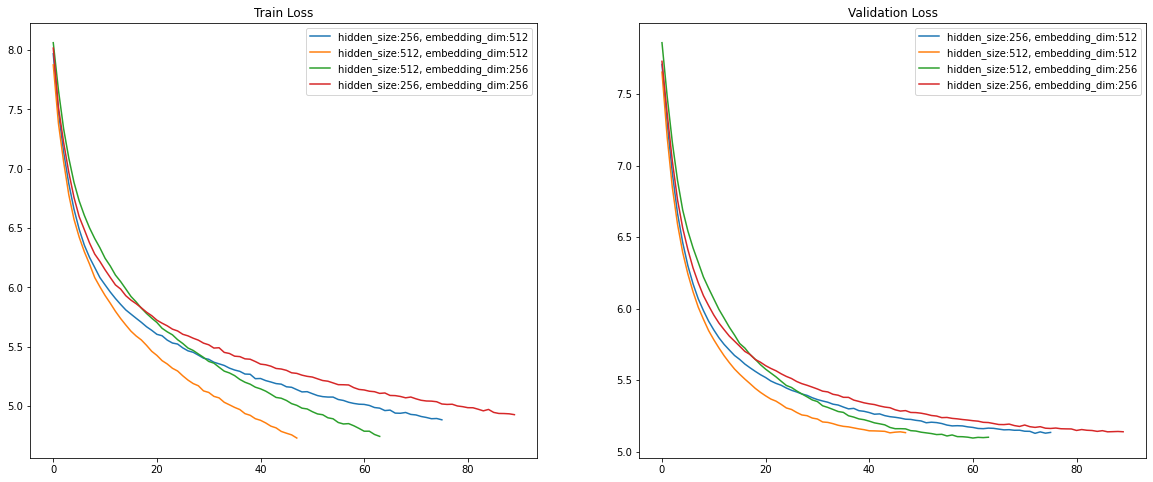

In [55]:
fig, (train, valid) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
for i in [2,3,4,5]:
    label = f"hidden_size:{model_options[i]['hidden_size']}, embedding_dim:{model_options[i]['embedding_dim']}"
    # draw four models in training set
    train.plot([loss[0] for loss in model_loss[i]], label = label)
    train.legend()
    train.set_title("Train Loss")
    # draw four models in validation set
    valid.plot([loss[1] for loss in model_loss[i]], label = label)
    valid.legend()
    valid.set_title("Validation Loss")
plt.show()

---
### 2 Learned embeddings (6 pts)
Next you will analyze the word embeddings that the model learns.


#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [ ]:
!pip install umap-learn

In [ ]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['split', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


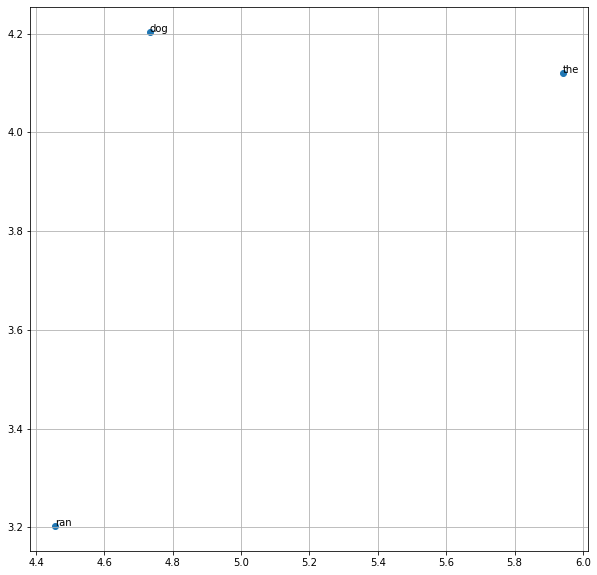

In [ ]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

In [ ]:
 reduced = umap.UMAP(min_dist=0.0001).fit_transform(fake_weight_matrix.detach().cpu().numpy())

#### 2.1 Word similarity (3 pts)


In [ ]:
def cosine_distance(word1, word2):
    d1 = np.sqrt(np.sum(np.power(word1, 2)))
    d2 = np.sqrt(np.sum(np.power(word2, 2)))
    return np.dot(word1, word2)/(d1 * d2)


In [ ]:
q2model = best_model
q2embedding = q2model.state_dict()['projection.weight']
embedding = q2embedding.detach().cpu().numpy()

33181

In [ ]:
words = ['dog', 'fast', 'pretty', 'home', 'play']
id_list = []
for element in range(len(data_dict)):
  id_list.append(element)
words_id_list = []
for i in words:
  word_id = data_dict.get_id(i)
  words_id_list.append(word_id)
unk_id = data_dict.get_id('<unk>')
pad_id = data_dict.get_id('<pad>')
new_id_list = []
for i in id_list:
  if i not in words_id_list and i != unk_id and i != pad_id:
    new_id_list.append(i)
new_id_list


In [ ]:
close10 = {}
far10 = {}
for id in words_id_list:
  scores=[]
  for other_id in new_id_list:
    score = cosine_distance(embedding[id], embedding[other_id])
    scores.append(score)
    sort_scores = sorted(scores, reverse=True)
    high10 = sort_scores[:10]
    low10 = sort_scores[-10:]
    high10_id = []
    low10_id = []
  for i in range(10):
    high10_id.append(scores.index(high10[i]))
    low10_id.append(scores.index(low10[i]))
  close10[id] = high10_id
  far10[id] = low10_id

In [ ]:
# 10 closest words 
close10_words={}
far10_words={}
for i in close10.keys():
  lc=[]
  for j in close10[i]:
    lc.append(data_dict.get_token(j))
  close10_words[data_dict.get_token(i)]=lc

for i in far10.keys():
  lf = []
  for j in far10[i]:
    lf.append(data_dict.get_token(j))
  far10_words[data_dict.get_token(i)]=lf

close10_words

{'dog': ['Demons',
  'classic',
  'bell',
  'persecution',
  'Lord',
  'oxen',
  'opponents',
  'excluded',
  'empire',
  'Trey'],
 'fast': ['Millennium',
  'cutscenes',
  'offers',
  'courtyards',
  'base',
  'Test',
  'Senate',
  'sophisticated',
  'hundreds',
  'instinct'],
 'home': ['studio',
  'personal',
  'gained',
  'Richards',
  'That',
  'runs',
  'however',
  '1908',
  'among',
  'again'],
 'play': ['plausible',
  'where',
  'football',
  'elected',
  'Margaret',
  'Gibson',
  'Regular',
  'blockade',
  'qualify',
  'these'],
 'pretty': ['Spy',
  'Lombardi',
  'hint',
  'gig',
  'Theater',
  'sonic',
  'promotional',
  'rim',
  'cinematographer',
  'unworthy']}

In [ ]:
# 10 furthest words
far10_words

{'dog': ['Hungarian',
  'sawgrass',
  'Fresnel',
  'transferring',
  'motorcycle',
  'IBC',
  'Caldecott',
  'award',
  'Chrono',
  'drift'],
 'fast': ['appointed',
  'doll',
  'PAS',
  'compensation',
  'Platoon',
  'Flores',
  'exclusivity',
  'semifinals',
  'Qin',
  '1931'],
 'home': ['Ecology',
  'lineages',
  'checkers',
  'pyramidal',
  'Talent',
  'zetlandicus',
  'Travelling',
  'expeditionary',
  'hypnosis',
  'est'],
 'play': ['logics',
  'Ferdan',
  'Mozambicans',
  'Manufactured',
  'Lowman',
  'Niobrara',
  'prairie',
  'rem',
  'graduate',
  "'easter"],
 'pretty': ['Văn',
  'lifted',
  'gauges',
  'unacceptable',
  'week',
  'leapt',
  'navigational',
  'operation',
  'chimney',
  '236']}

#### 2.2 UMAP (3 pts)

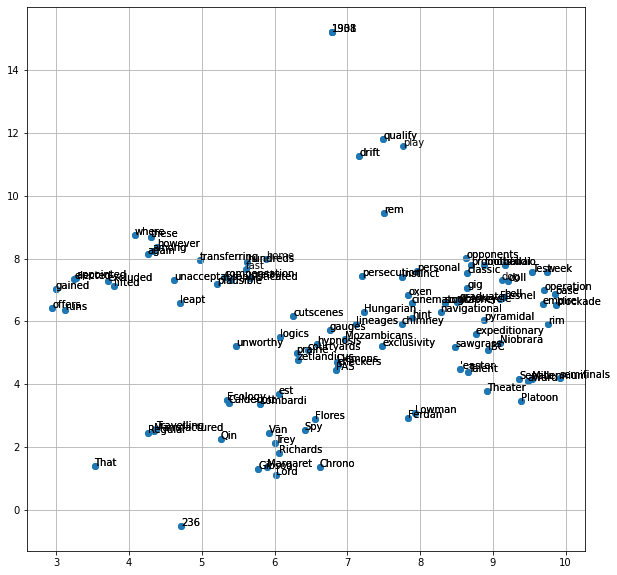

In [ ]:
for i in close10.keys():
    word_ids = [data_dict.get_id(i) for i in words] + close10[i] + far10[i]
    words = words + [data_dict.get_token(i) for i in close10[i]] + [data_dict.get_token(i) for i in far10[i]]

umap_plot(q2embedding, word_ids, words)

---
### 3 Sampling (14 pts)


#### 3.1 Sampling implementation (4 pts)

In [ ]:
batch = 1
h0 = torch.tensor(data_dict.get_id('<bos>'), dtype=torch.long).view(1, -1).to(current_device) #input
xt = data_dict.get_token(h0.item())# xt
ht = best_model.init_state(batch) #ht
sample_sq = ['<bos>']
while xt != '<eos>':
  proj_ht, ht = best_model(h0, ht)
  softmax = nn.Softmax(dim = batch)
  p = softmax(proj_ht)
  h0 = torch.multinomial(p, 1)
  xt = data_dict.get_token(h0.item())
  sample_sq.append(xt)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [ ]:
sample_sq

['<bos>',
 'remarkable',
 'Hydnellum',
 'is',
 'a',
 'U.S.',
 'myths',
 'as',
 'the',
 'new',
 'parish',
 ',',
 'The',
 'decks',
 ',',
 'and',
 'that',
 'After',
 'the',
 'HNC',
 ',',
 'to',
 'the',
 'Strand',
 ',',
 'as',
 'The',
 'story',
 '"',
 'The',
 'III',
 'at',
 'ransom',
 'and',
 'Another',
 'rule',
 ',',
 'one',
 'banked',
 'the',
 'locusts',
 '(',
 'In',
 'Sex',
 'The',
 'As',
 'the',
 'barrow',
 'in',
 'His',
 'dislike',
 'of',
 '"',
 'The',
 'Union',
 ',',
 'Korda',
 ')',
 '<eos>']

#### 3.2 1,000 samples and average log probability implementation (4 pts)

In [ ]:
sample = []
with torch.no_grad():
  total_logp = 0
  for i in range(1000):
    batch = 1
    h0 = torch.tensor(data_dict.get_id('<bos>'), dtype=torch.long).view(1, -1).to(current_device) #input
    xt = data_dict.get_token(h0.item())# xt
    ht = best_model.init_state(batch) #ht
    sample_sq = ['<bos>']
    while xt != '<eos>':
      proj_ht, ht = best_model(h0, ht)
      softmax = nn.Softmax(dim = batch)
      p = softmax(proj_ht)
      h0 = torch.multinomial(p, 1)
      xt = data_dict.get_token(h0.item())
      sample_sq.append(xt)
      logp = torch.log2(p[0][h0.item()])
      total_logp += logp
    sample.append(sample_sq)
  
  avg_logp = total_logp/1000
  print(avg_logp)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:582: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


tensor(-309.3929, device='cuda:0')


#### 3.3 Number of unique tokens and sequence length (3 pts)

(1,000 samples vs. 1,000 randomly selected validation-set sequences)


##### Validation Set

In [ ]:
# Get the validation dataset
import numpy as np
valid_data = datasets['valid']

# generate some random number as index for validation data
valid_index_list = []
while len(valid_index_list) < 1000:
  rand_index = np.random.randint(0,len(valid_data))
  if rand_index not in valid_index_list:
    valid_index_list.append(rand_index)

# get the length of sequences in validation data
valid_seq_num = []
for i in valid_index_list:
  valid_seq_num.append(len(valid_data[i]))

# Average sequence length
valid_avg_length = np.mean(valid_seq_num)
print('In validation set, the average sequence length is {}'.format(valid_avg_length))

In validation set, the average sequence length is 22.699


In [ ]:
# number of unique token
valid_seq = []
for i in valid_index_list:
  valid_seq.append(valid_data[i])

token_list = []
for i in valid_seq:
  for j in i:
    token_list.append(j)
valid_unique_num = len(set(token_list))
print('In validation set, the total number of unique tokens is {}'.format(valid_unique_num))

In validation set, the total number of unique tokens is 4959


##### Sampled sequences

In [ ]:
# get the length of sequences in sample data
sample_seq_len = np.mean([len(i) for i in sample])
print('In sample sequences, the average sequence length is {}'.format(sample_seq_len))

In sample sequences, the average sequence length is 42.826


In [ ]:
# get the number of unique token
sample_token_list = []
for i in sample:
  for j in i:
    sample_token_list.append(j)
sample_unique_num = len(set(sample_token_list))
print('In sample sequences, the total number of unique tokens is {}'.format(sample_unique_num))

In sample sequences, the total number of unique tokens is 8382


#### 3.4 Example samples (3 pts)

In [ ]:
for i in range(3):
  print(' '.join(sample[i]))

<bos> ( The atmospheric Hibiscus for The outlets ) <eos>
<bos> They are the Houghton , which is a T30 , to George was particularly " The An ground , in 5 @.@ evangelical The The Next ( , The However <eos>
<bos> Klaus lung and studies that A walls of Others at Old Film <eos>
